In [1]:
from gen_data import *
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from pdb import set_trace

In [93]:
# Here we define our model as a class
class RNN(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(RNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        #self.hidden = self.init_hidden()
        # Define the LSTM layer
        #self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.rnn = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers)
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_dim)
        
                
    def forward(self, x):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (h, c), where h and c both 
        # have shape (num_layers, batch_size, hidden_dim).
        hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.rnn(x,hidden)
        # print(lstm_out.shape)
        #print (self.lstm.weight_ih_l0)
        
        y_pred = self.linear(lstm_out.view(-1, self.hidden_dim))

        return y_pred


In [94]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        #self.hidden = self.init_hidden()
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        #self.lstm = nn.RNN(self.input_dim, self.hidden_dim, self.num_layers)
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
                
    def forward(self, x):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (h, c), where h and c both 
        # have shape (num_layers, batch_size, hidden_dim).
        hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.lstm(x,hidden)
        # print(lstm_out.shape)
        #print(self.hidden)
        
        y_pred = self.linear(lstm_out.view(-1, self.hidden_dim))

        return y_pred


In [95]:
#####################
# Generate data
#####################
num_train=80000
num_test=10000
task = Add_Task(6, 10, deterministic=True, tau_task=1)
data = task.gen_data(num_train, num_test)
X_train_a = data['train']['X']
y_train_a = data['train']['Y']#[:,0]
X_test_a = data['test']['X']
y_test_a = data['train']['Y']#[:,0]

# make training and test sets in torch
X_train = torch.from_numpy(X_train_a).type(torch.Tensor)
X_test = torch.from_numpy(X_test_a).type(torch.Tensor)
y_train = torch.from_numpy(y_train_a).type(torch.Tensor)
y_test = torch.from_numpy(y_test_a).type(torch.Tensor)


In [96]:
y_train_a

array([[0.5, 0.5],
       [0.5, 0.5],
       [1. , 0. ],
       ...,
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [97]:
#####################
# Set parameters
#####################
# Data params

# Network params
input_size = 2
batch_size = 1
# size of hidden layers
hidden_dim = 32
output_dim = 2
num_layers = 1
dtype = torch.float

X_train = X_train.view([-1, batch_size, input_size])
X_test = X_test.view([-1, batch_size, input_size])


In [98]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(-soft_targets * logsoftmax(pred),1))

In [99]:

model = RNN(input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model.linear.weight.data = torch.from_numpy(np.random.normal(0, np.sqrt(1/(hidden_dim)), (output_dim, hidden_dim)).astype(np.float32))
model.linear.bias.data = torch.from_numpy(np.zeros(output_dim).astype(np.float32))

model.rnn._parameters['weight_ih_l0'] = torch.from_numpy(np.random.normal(0, np.sqrt(1/(input_size)), (hidden_dim, input_size)))
model.rnn._parameters['weight_hh_l0'] = torch.from_numpy( np.linalg.qr(np.random.normal(0, 1, (hidden_dim, hidden_dim)))[0])
model.rnn._parameters['bias_hh_l0'] =torch.from_numpy(np.zeros(hidden_dim))

In [101]:
#####################
# Build model
#####################

#model = RNN(input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model = LSTM(input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
num_epochs = 10
learning_rate = 1
T = 10
#loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
rounds = num_train//T
#####################
# Train model
#####################

mons = []
lstm_loss_list_2 = []
model.hidden = model.init_hidden()
for t in range(num_epochs):
    
    # Forward pass
    for i in range(rounds):
        #set_trace()
        X_train_s = X_train[i*T:(i+1)*T]
        y_train_s = y_train[i*T:(i+1)*T]
        model.hidden = model.init_hidden()
        y_pred = model(X_train_s)
        loss = cross_entropy(y_pred, y_train_s)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()
        loss.backward()
        # Update parameters
        optimizer.step()
        
        mons.append(loss.item())
        progress = np.round((i/rounds)*100, 2)

        summary = '\rProgress: {}% complete \n'
        
        if i % 800 == 0 and i != 0:
            average_loss = sum(mons[-800:])/800
            lstm_loss_list_2.append(average_loss)
            summary += 'Average loss: {} \n'.format(average_loss)            
            print(summary.format(progress))
            



Progress: 10.0% complete 
Average loss: 0.666591983512044 

Progress: 20.0% complete 
Average loss: 0.6660896214842796 

Progress: 30.0% complete 
Average loss: 0.6649903603643179 

Progress: 40.0% complete 
Average loss: 0.6560185232013463 

Progress: 50.0% complete 
Average loss: 0.6541279522329568 

Progress: 60.0% complete 
Average loss: 0.6480639424920082 

Progress: 70.0% complete 
Average loss: 0.6436458519846201 

Progress: 80.0% complete 
Average loss: 0.6420902487635612 

Progress: 90.0% complete 
Average loss: 0.634462827630341 

Progress: 10.0% complete 
Average loss: 0.632664298042655 

Progress: 20.0% complete 
Average loss: 0.6241408245638013 

Progress: 30.0% complete 
Average loss: 0.6229861586168408 

Progress: 40.0% complete 
Average loss: 0.6192106395587325 

Progress: 50.0% complete 
Average loss: 0.6177431682869792 

Progress: 60.0% complete 
Average loss: 0.6136436964198947 

Progress: 70.0% complete 
Average loss: 0.6137582955136895 

Progress: 80.0% complete 
A

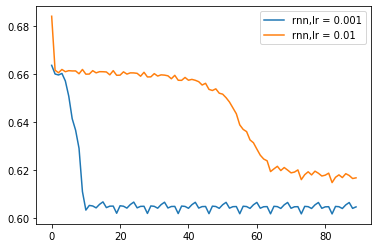

In [89]:
#####################
# Plot preds and performance
#####################
rnn_loss_list
rnn_loss_list_2
# lstm_loss_list
# lstm_loss_list_2
plt.plot(rnn_loss_list,label="rnn,lr = 0.001")
plt.plot(rnn_loss_list_2,label="rnn,lr = 0.01")
plt.plot(rnn_loss_list,label="lstm,lr = 0.1")
plt.plot(rnn_loss_list_2,label="lstm,lr = 1")

plt.legend()
plt.show()


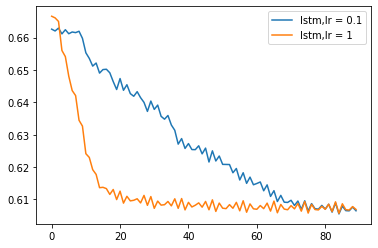

In [102]:
plt.plot(lstm_loss_list,label="lstm,lr = 0.1")
plt.plot(lstm_loss_list_2,label="lstm,lr = 1")

plt.legend()
plt.show()


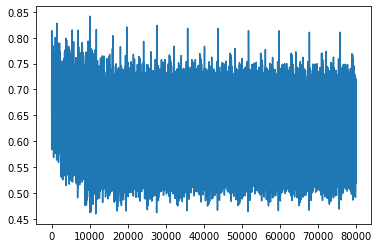

In [103]:
plt.plot(mons)

0.6819950342178345

In [2]:
from lstm_network import LSTM
from functions import *

task = Add_Task(6, 10, deterministic=True, tau_task=1)
data = task.gen_data(30, 10000) #10000000


n_in = task.n_in
n_h = 16
n_out = task.n_out
n_h_hat = n_h + n_in
n_t = 2 * n_h

W_f  = np.random.normal(0, np.sqrt(1/(n_h_hat)), (n_h, n_h_hat))
W_i  = np.random.normal(0, np.sqrt(1/(n_h_hat)), (n_h, n_h_hat))
W_a  = np.random.normal(0, np.sqrt(1/(n_h_hat)), (n_h, n_h_hat))
W_o  = np.random.normal(0, np.sqrt(1/(n_h_hat)), (n_h, n_h_hat))
b_f = np.zeros(n_h)
b_i = np.zeros(n_h)
b_a = np.zeros(n_h)
b_o = np.zeros(n_h)
W_out = np.random.normal(0, np.sqrt(1/(n_t)), (n_out, n_t))
b_out = np.zeros(n_out)


my_lstm = LSTM(W_f, W_i, W_a, W_o, W_out, 
            b_f, b_i, b_a, b_o, b_out,
            output=softmax,
            loss=softmax_cross_entropy)


In [10]:
lstm = nn.LSTM(2, 16, 1)

In [11]:
W_i = torch.cat([lstm._parameters['weight_ih_l0'][:16],lstm._parameters['weight_hh_l0'][:16]],1).cpu().detach().numpy()
W_f = torch.cat([lstm._parameters['weight_ih_l0'][16:32],lstm._parameters['weight_hh_l0'][16:32]],1).cpu().detach().numpy()
W_a = torch.cat([lstm._parameters['weight_ih_l0'][32:48],lstm._parameters['weight_hh_l0'][32:48]],1).cpu().detach().numpy()
W_o = torch.cat([lstm._parameters['weight_ih_l0'][48:64],lstm._parameters['weight_hh_l0'][48:64]],1).cpu().detach().numpy()

b_f = np.zeros(n_h)
b_i = np.zeros(n_h)
b_a = np.zeros(n_h)
b_o = np.zeros(n_h)


lstm._parameters['bias_ih_l0']=torch.zeros(64)
lstm._parameters['bias_hh_l0']=torch.zeros(64)

In [12]:
my_lstm = LSTM(W_f, W_i, W_a, W_o, W_out, 
            b_f, b_i, b_a, b_o, b_out,
            output=softmax,
            loss=softmax_cross_entropy)

In [13]:
hidden = (torch.zeros(1, 1, 16),
                torch.zeros(1, 1, 16))

X_train = torch.from_numpy(data['train']['X'][0]).type(torch.Tensor)
X_train = X_train.view([-1, 1, 2])

lstm_out= lstm(X_train,hidden)


In [3]:
my_out = my_lstm.next_state(data['train']['X'][0],h=np.zeros(16),c=np.zeros(16),update=False)

array([ 0.10709971,  0.15956354,  0.04318108, -0.02641258, -0.01841896,
       -0.04292943,  0.11215756, -0.09256548,  0.25709211, -0.04909238,
        0.05638075, -0.09317969,  0.08566954,  0.12128232, -0.04772455,
        0.10131517])

In [16]:
lstm_out

(tensor([[[ 0.0866,  0.0148,  0.1522, -0.0563,  0.0392,  0.0636, -0.0145,
            0.0885, -0.0555, -0.0072,  0.0590,  0.0288, -0.0787,  0.0550,
            0.0494,  0.1714]]], grad_fn=<StackBackward>),
 (tensor([[[ 0.0866,  0.0148,  0.1522, -0.0563,  0.0392,  0.0636, -0.0145,
             0.0885, -0.0555, -0.0072,  0.0590,  0.0288, -0.0787,  0.0550,
             0.0494,  0.1714]]], grad_fn=<StackBackward>),
  tensor([[[ 0.1731,  0.0291,  0.3137, -0.1126,  0.0936,  0.1224, -0.0316,
             0.1978, -0.1061, -0.0168,  0.1338,  0.0665, -0.2019,  0.0983,
             0.1011,  0.3554]]], grad_fn=<StackBackward>)))

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x)) # max(x) subtracted for numerical stability
    return e_x / np.sum(e_x)


def forward_step(x, h_prev, c_prev):
    z = np.append(h_prev, x, axis=0)#np.row_stack((h_prev, x))

    f = sigmoid(np.dot(W_f, z) + b_f)
    i = sigmoid(np.dot(W_i, z) + b_i)
    c_bar = np.tanh(np.dot(W_a, z) + b_a)

    c = f * c_prev + i * c_bar
    o = sigmoid(np.dot(W_o, z) + b_o)
    h = o * np.tanh(c)

#     v = np.dot(W_out, h) + b_out
#     y_hat = softmax(v)
    return h, c



In [5]:
forward_step(x=data['train']['X'][0],h_prev=np.zeros(16),c_prev=np.zeros(16))

(array([ 0.01380777,  0.03348634,  0.01373534,  0.00745883, -0.07164816,
         0.01037488, -0.06974243,  0.06142398,  0.04629351, -0.0427742 ,
         0.10782359,  0.12576076, -0.07926801, -0.02103119,  0.03654132,
         0.0369412 ]),
 array([ 0.04015545,  0.07005828,  0.02911165,  0.01191787, -0.17017264,
         0.02690068, -0.11094298,  0.1164085 ,  0.08744963, -0.07405329,
         0.20544801,  0.25344587, -0.16383056, -0.04744368,  0.08142878,
         0.07641289]))

In [6]:
my_out[:16]

array([ 0.04015545,  0.07005828,  0.02911165,  0.01191787, -0.17017264,
        0.02690068, -0.11094298,  0.1164085 ,  0.08744963, -0.07405329,
        0.20544801,  0.25344587, -0.16383056, -0.04744368,  0.08142878,
        0.07641289])

In [7]:
my_out[16:32]

array([ 0.01380777,  0.03348634,  0.01373534,  0.00745883, -0.07164816,
        0.01037488, -0.06974243,  0.06142398,  0.04629351, -0.0427742 ,
        0.10782359,  0.12576076, -0.07926801, -0.02103119,  0.03654132,
        0.0369412 ])